In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from scipy.integrate import quad
from scipy.stats import gamma
import scipy.special as sc

In [2]:
def draw_graph(G):
    elarge = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] > 0.5]
    esmall = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] <= 0.5]

    pos = nx.spring_layout(G, seed=7)  # positions for all nodes - seed for reproducibility

    # nodes
    nx.draw_networkx_nodes(G, pos, node_size=700)

    # edges
    nx.draw_networkx_edges(G, pos, edgelist=elarge, width=3)
    nx.draw_networkx_edges(
        G, pos, edgelist=esmall, width=3, alpha=0.5, edge_color="b", style="dashed"
    )

    # node labels
    nx.draw_networkx_labels(G, pos, font_size=20, font_family="sans-serif")
    # edge weight labels
    edge_labels = nx.get_edge_attributes(G, "weight")
    nx.draw_networkx_edge_labels(G, pos, edge_labels)

    ax = plt.gca()
    ax.margins(0.08)
    plt.axis("off")
    plt.tight_layout()
    plt.show()

def find_next_child(G, source_node):
    child_node = None
    max_weight = 0
    for node in source_node:
        for neighbor in G.neighbors(node):
            #print(f"neighbor is {neighbor}")
            if neighbor not in source_node:
                weight = G[node][neighbor]['weight']
                if weight > max_weight:
                    max_weight = weight
                    child_node = neighbor
                    #print(f"child node is {child_node}")
    return child_node

def find_parents(i, G, source=['s']):
    parent_node = []
    # First get all the neighbors of node i
    candidate = G.neighbors(i)
    for n in candidate:
        # Find the nodes in the source set
        if n in source:
            parent_node.append(n)
    return parent_node

# We use theta instead of r in the paper.
def compute_ccdf(x, k, theta):
    return 1 - gamma.cdf(x, k, scale=theta)

I = ['s']
def product_ccdf(t, j, k, theta):
    v = 1
    for par in find_parents(j, G, source=I):
        v *= compute_ccdf(t, k[par], theta[par])
    return v

def integrand_moment(t, j, k, theta, p):
    return p * t**(p - 1) * product_ccdf(t, j, k, theta)

def compute_moment(j, k, theta, p):
    return quad(integrand_moment, 0, np.inf, args=(j, k, theta, p))[0]

# Calculate k and r for node a
def compute_theta(E, V, lambda_p):
    return (E + 1/lambda_p) / (V + 1/lambda_p**2)

def compute_k(E, V, lambda_p):
    return (E + 1/lambda_p)**2 / (V + 1/lambda_p**2)

def compute_expectation(k1, r1, k2, r2):
  beta_top = sc.betainc(k2+1, k1, r2/(r1+r2))
  beta_down = sc.betainc(k2, k1, r2/(r1+r2))
  expectation = (k1+k2) / r1 - k2*(r1+r2) / (r1*r2) * (beta_top / beta_down)
  return 1/expectation

Considering a simple circle graph with equal weight, we can simply choose any of the nodes as the source node by symmetry.

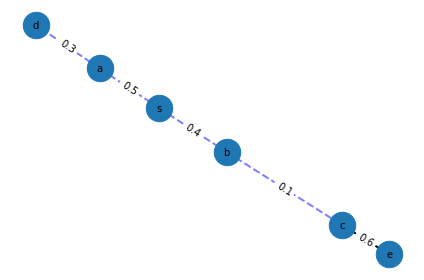

In [3]:
G = nx.Graph()
G.add_nodes_from(["s", "a", "b", "c", "d", "e"])
G.add_edge("s", "a", weight=0.5)
G.add_edge("s", "b", weight=0.4)
G.add_edge("a", "d", weight=0.3)
G.add_edge("b", "c", weight=0.1)
G.add_edge("c", "e", weight=0.6)

def draw_graph(G):
    elarge = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] > 0.5]
    esmall = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] <= 0.5]

    pos = nx.spring_layout(G, seed=7)  # positions for all nodes - seed for reproducibility

    # nodes
    nx.draw_networkx_nodes(G, pos, node_size=700)

    # edges
    nx.draw_networkx_edges(G, pos, edgelist=elarge, width=2)
    nx.draw_networkx_edges(
        G, pos, edgelist=esmall, width=2, alpha=0.5, edge_color="b", style="dashed"
    )

    # node labels
    nx.draw_networkx_labels(G, pos, font_size=10, font_family="sans-serif")
    # edge weight labels
    edge_labels = nx.get_edge_attributes(G, "weight")
    nx.draw_networkx_edge_labels(G, pos, edge_labels)

    ax = plt.gca()
    ax.margins(0.08)
    plt.axis("off")
    plt.tight_layout()
    plt.show()

draw_graph(G)

In [4]:
print(f"The next child node of source {['s']} is {find_next_child(G, ['s'])}.")
print(find_parents('a', G, source=['s']))

The next child node of source ['s'] is a.
['s']


In [5]:
lambda_sa = G.get_edge_data('s', 'a')['weight']
#print(lambda_sa)

# Assume k and r are both 1 for node s with expectation and variance are 1.
theta_s = 1
k_s = 2
E_s = k_s/theta_s
V_s = k_s/theta_s**2

# Calculate k and r for node a
def compute_theta(E, V, lambda_p):
    return (E + 1/lambda_p) / (V + 1/lambda_p**2)

def compute_k(E, V, lambda_p):
    return (E + 1/lambda_p)**2 / (V + 1/lambda_p**2)

theta_a = compute_theta(E_s, V_s, lambda_sa)
k_a = compute_k(E_s, V_s, lambda_sa)

print(theta_a, k_a)

0.6666666666666666 2.6666666666666665


In [6]:
j = 'a'
k = {'s': k_s}
theta = {'s': theta_s}

moment_1 = compute_moment('s', k, theta, 1)
moment_2 = compute_moment('s', k, theta, 2)

<ipython-input-2-bc34103d9c42>:67: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return quad(integrand_moment, 0, np.inf, args=(j, k, theta, p))[0]


In [7]:
lambda_sa_1 = compute_expectation(k_a, theta_a, k_s, theta_s)
lambda_sa_2 = float('%.3f'%lambda_sa_1)

['s', 'a']
0.335


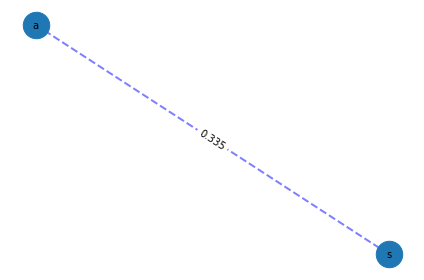

In [8]:
T = nx.Graph()
T.add_edge('a', 's', weight=lambda_sa_2)
I.append('a')
print(I)

print(lambda_sa_2)
draw_graph(T)

In [9]:
next_node = find_next_child(G, I)
print(f"next node is {next_node}.")

next node is b.


In [10]:
lambda_1 = G.get_edge_data('s', next_node)['weight']
#lambda_2 = G.get_edge_data('a', next_node)['weight']

# For node s, we now compute the k and r
k_bs = compute_k(E_s, V_s, lambda_1)
theta_bs = compute_theta(E_s, V_s, lambda_1)
print(k_bs, theta_bs)

k_1 = {'s': k_s, 'a': k_a, 'b': k_bs}
theta_1 = {'s': theta_s, 'a': theta_a, 'b': theta_bs}

2.4545454545454546 0.5454545454545454


In [11]:
E_a = moment_1
V_a = moment_2 - moment_1**2

k_bs = compute_k(E_s, V_s, lambda_1)
theta_bs = compute_theta(E_s, V_s, lambda_1)
print(k_bs, theta_bs)
#k_ba = compute_k(E_a, V_a, lambda_2)
#theta_ba = compute_theta(E_a, V_a, lambda_2)
#print(k_ba, theta_ba)

moment_1_bs = compute_moment('s', k_1, theta_1, 1)
moment_2_bs = compute_moment('s', k_1, theta_1, 2)
#moment_1_ba = compute_moment('a', k_1, theta_1, 1)
#moment_2_ba = compute_moment('a', k_1, theta_1, 2)

print(moment_1_bs, moment_2_bs, moment_2_bs - moment_1_bs**2)
#print(moment_1_ba, moment_2_ba, moment_2_ba - moment_1_ba**2)

2.4545454545454546 0.5454545454545454
1.7777777777808363 4.345679012345531 1.1851851851741628


In [12]:
# Node s is the infection parent of node b
E_b = moment_1_bs
V_b = moment_2_bs - moment_1_bs**2

lambda_sb_1 = compute_expectation(k_bs, theta_bs, k_s, theta_s)
lambda_sb_2 = float('%.3f'%lambda_sb_1)
print(lambda_sb_1)

0.28763667991243386


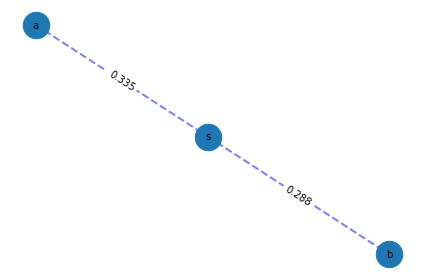

In [13]:
I.append(next_node)
T.add_edge('s', next_node, weight=lambda_sb_2)

draw_graph(T)

In [14]:
##find next node 'd'
j = find_next_child(G, I)
print(j)


d


In [15]:
#find its candidate parents
parent = find_parents('d', G, I)
print(parent)

['a']


In [16]:
lambda_d1 = G.get_edge_data(parent[0], j)['weight']
#lambda_d2 = G.get_edge_data('b', j)['weight']

k_da = compute_k(E_a, V_a, lambda_d1)   
theta_da = compute_theta(E_a, V_a, lambda_d1)
k_2 = {'s': k_s, 'a': k_a, 'd': k_da, 'b':k_bs}
theta_2 = {'s': theta_s, 'a': theta_a, 'b': theta_bs, 'd': theta_da}

moment_1_da = compute_moment('a', k_2, theta_2, 1)
moment_2_da = compute_moment('a', k_2, theta_2, 2)

print(moment_1_da, moment_2_da, moment_2_da - moment_1_da**2)

1.9999999999999996 6.0000000000000036 2.0000000000000053


In [17]:
# Node a is the infection parent of node d
E_d = moment_1_da
V_d = moment_2_da - moment_1_da**2

lambda_da_1 = compute_expectation(k_da, theta_da, k_a, theta_a)
lambda_da_2 = float('%.3f'%lambda_da_1)
print(lambda_da_1)

0.2783971288622211


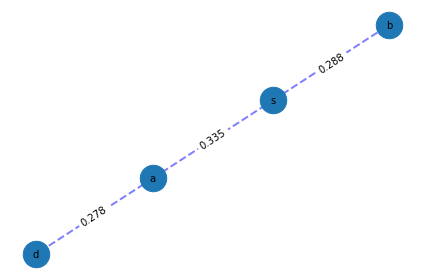

In [18]:
I.append(j)
T.add_edge('a', j, weight=lambda_da_2)

draw_graph(T)

In [19]:
next_node = find_next_child(G, I)
print(f"next node is {next_node}.")

next node is c.


In [20]:
#find its candidate parents
parent = find_parents('c', G, I)
print(parent)

['b']


In [21]:
lambda_c1 = G.get_edge_data(parent[0], next_node)['weight']
#lambda_d2 = G.get_edge_data('b', j)['weight']

k_cb = compute_k(E_b, V_b, lambda_c1)   
theta_cb = compute_theta(E_b, V_b, lambda_c1)
k_3 = {'s': k_s, 'c': k_cb, 'a': k_a, 'd': k_da, 'b':k_bs}
theta_3 = {'s': theta_s, 'c': theta_cb, 'a': theta_a, 'b': theta_bs, 'd': theta_da}

moment_1_cb = compute_moment('b', k_3, theta_3, 1)
moment_2_cb = compute_moment('b', k_3, theta_3, 2)

print(moment_1_cb, moment_2_cb, moment_2_cb - moment_1_cb**2)

1.9999999999999996 6.0000000000000036 2.0000000000000053


In [22]:
# Node b is the infection parent of node c
E_c = moment_1_cb
V_c = moment_2_cb - moment_1_cb**2

lambda_cb_1 = compute_expectation(k_cb, theta_cb, k_bs, theta_bs)
lambda_cb_2 = float('%.3f'%lambda_cb_1)
print(lambda_cb_1)

0.0941515382021907


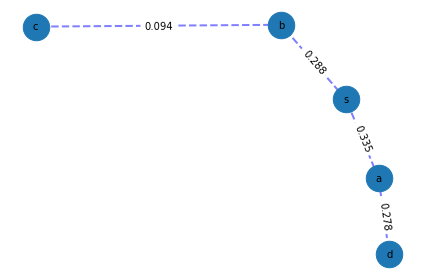

In [23]:
I.append(next_node)
T.add_edge('b', next_node, weight=lambda_cb_2)

draw_graph(T)

In [24]:
next_node = find_next_child(G, I)
print(f"next node is {next_node}.")

next node is e.


In [25]:
#find its candidate parents
parent = find_parents('e', G, I)
print(parent)

['c']


In [26]:
lambda_e1 = G.get_edge_data(parent[0], next_node)['weight']
#lambda_d2 = G.get_edge_data('b', j)['weight']

k_ec = compute_k(E_c, V_c, lambda_e1)   
theta_ec = compute_theta(E_c, V_c, lambda_e1)
k_4 = {'s': k_s, 'c': k_cb, 'a': k_a, 'd': k_da, 'b':k_bs, 'e': k_ec}
theta_4 = {'s': theta_s, 'c': theta_cb, 'a': theta_a, 'b': theta_bs, 'd': theta_da, 'e': theta_ec}

moment_1_ec = compute_moment('c', k_4, theta_4, 1)
moment_2_ec = compute_moment('c', k_4, theta_4, 2)

print(moment_1_ec, moment_2_ec, moment_2_ec - moment_1_ec**2)

1.3388429752186406 2.5227784987356707 0.7302779864433693


In [27]:
# Node e is the infection parent of node c
E_e = moment_1_ec
V_e = moment_2_ec - moment_1_ec**2

lambda_ec_1 = compute_expectation(k_ec, theta_ec, k_cb, theta_cb)
lambda_ec_2 = float('%.3f'%lambda_ec_1)
print(lambda_ec_1)

0.4162709165533555


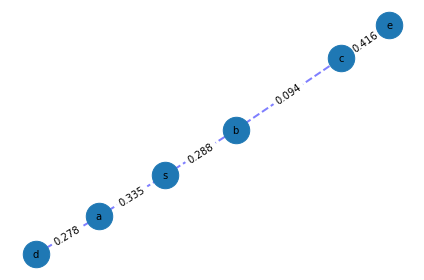

In [28]:
I.append(next_node)
T.add_edge('c', next_node, weight=lambda_ec_2)

draw_graph(T)

In [33]:
from MessagePassing import *

In [30]:
print(T.nodes())

['a', 's', 'b', 'd', 'c', 'e']


In [31]:
# nx.draw_networkx_labels(T, pos=nx.spring_layout(T, seed=0), font_size=12)

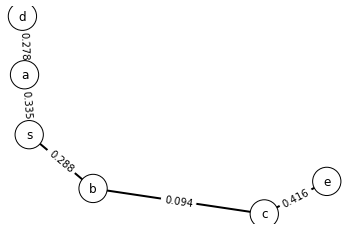

The most likely source nodes are: {'s'} 
 the corresponding likelyhood probability value is 1.113280163341313 
 the index of the ovservation time correspond to node s  is  10


interactive(children=(IntSlider(value=1, description='index of the observation time', layout=Layout(width='500…

the darker the node color, the larger probability for the node to be the source


In [34]:
MP_weighted(T, T.nodes(), T_max=5, num_T_positions=10)